[('normals', '<f4', (3,)), ('vectors', '<f4', (3, 3)), ('attr', '<u2', (1,))]


C:\Users\terry\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead


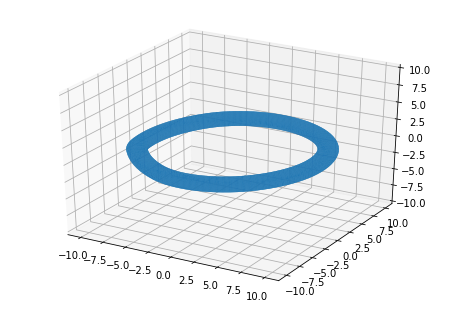

In [2]:
import math
import numpy as np
from stl import mesh
from mpl_toolkits import mplot3d
from matplotlib import pyplot

def reuleaux(i, j, k, thickness):
    """A torus with Reuleaux Triangle cross-section: See https://en.wikipedia.org/wiki/Reuleaux_triangle"""
    major_radius = 1.4
    minor_radius = 0.3
    rad = (j / 10.0 - 1) * math.pi / 3.0
    # Using Polar equation of a circle from https://en.wikipedia.org/wiki/Polar_coordinate_system#Circle
    # R=1, r0=1/sqrt(3) (2/3 height of unit sided equilateral triangle, offset of centre of reuleaux arc)
    cosr = math.cos(rad)
    r = (math.sqrt(4.0/3.0*cosr*cosr + 8.0/3.0) - 2.0/math.sqrt(3.0)*cosr)/2.0 
    az = i / 100.0 * math.pi * 2.0 
    rot = az*2/3
    degrees = (rot/math.pi*180+30)%120-30
    def cos_deg(d):
        return math.cos(d/180*math.pi)
    if degrees<30:
        r0 = 1-cos_deg(degrees)/math.sqrt(3.0)
    else:
        r0 = cos_deg(degrees-60)/math.sqrt(3.0)
    th = rad + k*math.pi*2/3 + rot  #twist it!
    #based on parametric equation of a torus
    reuleaux = r * math.cos(th) - r0 - 0.5;
    full_radius = major_radius + minor_radius * reuleaux;
    x = math.sin(-az) * full_radius
    y = math.cos(-az) * full_radius
    z = r * math.sin(th)
    return np.array([x, y, z])

VERTEX_COUNT = 100*20*3
print(mesh.Mesh.dtype)
data = np.zeros((100,20,3,2), dtype=mesh.Mesh.dtype)
scale = 10
for i in range(100):
    for j in range(20):
        for k in range(3):
            #quadrilateral patch of surface made of two triangles
            p0 = reuleaux(i,j,k)*scale
            p1 = reuleaux(i+1,j,k)*scale
            p2 = reuleaux(i+1,j+1,k)*scale
            p3 = reuleaux(i,j+1,k)*scale
            data[i,j,k,0][1] = [p0, p1, p2]
            data[i,j,k,1][1] = [p2, p3, p0]
            #print(data[i,j,k])
ring_mesh = mesh.Mesh(data.flatten(), remove_empty_areas=False)
#Plot it
figure = pyplot.figure()
axes = mplot3d.Axes3D(figure)
axes.add_collection3d(mplot3d.art3d.Poly3DCollection(ring_mesh.vectors))
scale = ring_mesh.points.flatten(-1)
axes.auto_scale_xyz(scale, scale, scale)
pyplot.show()
ring_mesh.save('ring{}.stl'.format(thickness))